In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

This part of the exploratory comoponent will try to answer the question: can the end station of a trip be predicted starting from a single known station?
It is our belief that this is a hugely interesting topic to inverstigate, which will be done through two of the techniques learnt during the course: neural networks and a Tree Forest Classifier. 

First of all, all the relevant data needs to be loaded, which includes the pickups information as well as the wheather data and national holidays dates, which will be added as a column with a binary value (1 indicating that the day is indeed a national holiday and 0 otherwise).
Once this is achieved, both dataframes will be merged by date. Since the nature of this problem calls for keeping each pickup as a separate instance in the dataframe, the merge will happen on the pickups data side.


In [2]:
data_exp=pd.read_csv('BikeSharing_Bluebikes2022.csv')
nat_hol = ['2022-01-01','2022-01-17','2022-02-21','2022-04-17','2022-04-18','2022-05-08','2022-05-30','2022-06-19','2022-06-20','2022-07-04']

data_exp['is_Holiday'] = [ 1 if data_exp.iloc[i]['starttime'][0:10] in nat_hol else 0 for i in range(len(data_exp))]


As we have seen before, there is data in the wheather dataframe which is highly correlated with each other, like 'temp' and 'tempmax' for example, while others are not relevant at all to our study. All of these features will be dropped.

In [3]:
data_w = pd.read_csv("Boston 2022-01-01 to 2022-08-31.csv")
drop = ['dew', 'sunrise','sunset','moonphase','conditions', 'description','stations','sealevelpressure',
'windgust','severerisk', 'uvindex', 'solarenergy', 'solarradiation','preciptype','winddir','name'
,'tempmax', 'tempmin','feelslikemax', 'feelslikemin','precipprob', 'precipcover']
data_w = data_w.drop(columns = drop)
data_w['datetime'] = pd.to_datetime(data_w['datetime'])

In [898]:
from datetime import datetime as dt

data_exp['starttime'] = pd.to_datetime(data_exp['starttime'], format='%Y-%m-%d %H:%M:%S')
data_exp['datetime'] = pd.to_datetime(data_exp['starttime']).dt.date
data_exp['datetime'] = pd.to_datetime(data_exp['datetime'])

data_merge = data_exp.merge(data_w, how='left', on='datetime')

In [899]:
data_merge.columns
data_merge = data_merge.drop(columns=(['Unnamed: 0']))

In [900]:
data_merge.columns


Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'is_Holiday', 'datetime', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'icon'],
      dtype='object')

In [901]:
data_merge['start station id']

0          178
1          189
2           94
3           94
4           19
          ... 
2305730     67
2305731    380
2305732    150
2305733    105
2305734    560
Name: start station id, Length: 2305735, dtype: int64

In order to conduct a coherent study, we need to choose the start station with sufficient data, which means counting the instances of each start station and creating a new dataframe including only those from the most repeated one.

In [902]:
list = []
for i in data_merge['start station id'].unique():
    count = data_merge[data_merge['start station id']==i].count()[0]
    list.append(count)

maxim = data_merge['start station id'].unique()[list.index(max(list))]
print(maxim)
data_merge[data_merge['start station id']==maxim].count()[0]



67


49127

In this case, station 67 happens to be the most frequent, with a total count of almost fifty thousand data points.

In [903]:
data_merge[data_merge['start station id']!=67]['start station id'].mode()

0    68
Name: start station id, dtype: int64

In [904]:
data_merge[data_merge['start station id']==68].count()[0]

40999

In [905]:
data_merge = data_merge[data_merge['start station id'].isin([67,68])]

In [906]:
data_merge['start station id']

33         68
35         68
56         68
62         67
67         68
           ..
2305598    67
2305608    67
2305623    67
2305661    67
2305730    67
Name: start station id, Length: 90126, dtype: int64

It is also important to investigate how balanced our data is, since having a couple of end stations with a huge number of entries can lead to unclear prediction models.

In [907]:
dic_stations = {}
for i in data_merge['end station id']:
    if str(i) in dic_stations.keys():
        dic_stations[str(i)] +=1
    else:
        dic_stations[str(i)] = 1

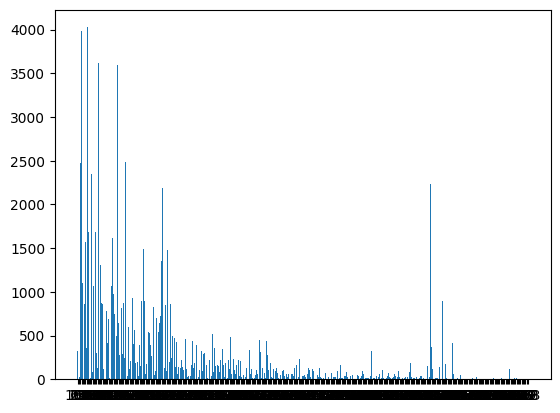

In [908]:
plot = plt.bar(*zip(*dic_stations.items()))
plt.show()

As we can see in the plot above, there are a handful of stations that can skew the data. As such we will only select those end stations that fall into a certain range of instances

In [980]:
excluded_stations = []
for i in data_merge['end station id'].unique():
    count = data_merge[data_merge['end station id']==i].count()[0]
    if 2300 < count :
        continue
    else:
        excluded_stations.append(i)

print(len(excluded_stations),len(data_merge['end station id'].unique()))

2 9


As a result of this exploration, 187 stations and their respective data will be eliminated from the dataset

In [981]:
data_merge = data_merge[~data_merge['end station id'].isin(excluded_stations)]

In [982]:
len(data_merge['end station id'].unique())

7

Next, we also need to get rid of the unnecessary features coming from the pickups file, including the start station id since they are all from the same station now.

In [983]:
data_merge.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'is_Holiday', 'datetime', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'icon'],
      dtype='object')

In [984]:
data_nn = data_merge.drop(columns=[
       'start station name', 'start station latitude',
       'start station longitude','end station name',
       'end station latitude', 'end station longitude','bikeid','postal code', 'stoptime'])

Our data is looking like this at the moment. There are obvious steps to be taken before training of any kind can begin to occur: 
First of all, the time in which those pickups happen can not be a simple date since it can not be picked up by models. Therefore, we have decided to transform the time of the pickup into a new variable expressing the time of day in which the pickup happened. The division will happen every six hours into morning, afternoon, evening and night. These are really valuable information and more importantly, usable by getting their dummies.
Once this is done, both columns indicating the date and time of the pickup can be dropped from the dataframe.

In [985]:
data_nn['time_of_day'] = 0
for i in range(len(data_nn)):
    if (data_nn['starttime'].iloc[i].hour >= 7) & (data_nn['starttime'].iloc[i].hour < 12):
        data_nn['time_of_day'].iloc[i] = 'morning'
    elif (data_nn['starttime'].iloc[i].hour >= 12) & (data_nn['starttime'].iloc[i].hour < 17):
        data_nn['time_of_day'].iloc[i] = 'afternoon'
    elif (data_nn['starttime'].iloc[i].hour >= 17) & (data_nn['starttime'].iloc[i].hour < 24):
        data_nn['time_of_day'].iloc[i] = 'evening'
    elif (data_nn['starttime'].iloc[i].hour >= 24) or (data_nn['starttime'].iloc[i].hour < 7):
        data_nn['time_of_day'].iloc[i] = 'night'


C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\1358740847.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['time_of_day'].iloc[i] = 'night'


In [986]:
len(data_nn[data_nn['end station id']==471])

2347

In [987]:
data_nn

,tripduration,starttime,start station id,end station id,usertype,is_Holiday,datetime,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,icon,time_of_day
56,509,2022-01-01 00:27:40.984,68,107,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain,night
62,2209,2022-01-01 00:29:15.682,67,67,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain,night
150,320,2022-01-01 01:18:18.033,68,178,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain,night
333,387,2022-01-01 03:31:04.764,68,178,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain,night
377,204,2022-01-01 03:56:38.414,67,471,Subscriber,1,2022-01-01,8.3,7.6,98.2,1.225,0.0,0.0,11.0,100.0,3.0,rain,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305014,228,2022-08-31 23:29:02.443,67,471,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain,evening
2305157,529,2022-08-31 23:35:22.510,68,471,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain,evening
2305276,494,2022-08-31 23:40:14.734,68,179,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain,evening
2305566,356,2022-08-31 23:52:55.882,67,179,Subscriber,0,2022-08-31,25.0,25.0,63.1,8.351,0.0,0.0,31.6,49.3,16.0,rain,evening


In [988]:
data_nn['starttime'].iloc[0].weekday()

5

In [989]:
data_nn['is_weekend'] = 1  
weekday = 5 ## 2022 starts on a saturday
day = data_nn['starttime'].iloc[0].day
for i in range(1,len(data_nn)):
    data_nn['is_weekend'].iloc[i] = 1 if (
    data_nn['starttime'].iloc[i].weekday()) > 4 else 0
    if data_nn['starttime'].iloc[i].weekday() == 4 and data_nn['time_of_day'].iloc[i] == 'evening':
        data_nn['is_weekend'].iloc[i] = 1

C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\1496866577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['is_weekend'].iloc[i] = 1 if (
C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\1496866577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['is_weekend'].iloc[i] = 1


In [990]:
data_nn.iloc[2000]

tripduration                              1956
starttime           2022-02-09 17:33:56.854000
start station id                            67
end station id                             178
usertype                            Subscriber
is_Holiday                                   0
datetime                   2022-02-09 00:00:00
temp                                       1.8
feelslike                                 -2.3
humidity                                  56.4
precip                                     0.0
snow                                       0.0
snowdepth                                  5.2
windspeed                                 28.9
cloudcover                                19.8
visibility                                16.0
icon                                 clear-day
time_of_day                            evening
is_weekend                                   0
Name: 107311, dtype: object

In [991]:
data_nn = data_nn.drop(columns=['starttime','datetime'])

Second step into getting the data ready for training is using dummy variables to codify those that are not numerical values. The time of day variable has already been discussed, but the icon variable and usertype, which define the general wheather for that day and the type of user (subscriber or customer) respectively, also need to be translated into dummy variables.

In [992]:
data_nn_dummies = pd.get_dummies(data_nn, columns=['time_of_day', 'icon', 'usertype','start station id'])

In [993]:
data_nn_dummies_std = data_nn_dummies.copy()

In [994]:
data_nn_dummies_std.columns

Index(['tripduration', 'end station id', 'is_Holiday', 'temp', 'feelslike',
       'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover',
       'visibility', 'is_weekend', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'icon_snow', 'usertype_Customer', 'usertype_Subscriber',
       'start station id_67', 'start station id_68'],
      dtype='object')

Since most of our numerical features are using different scales, we need to standardize these columns. 
It is also important to remark that our dummy variables have not been standardized, since this would defeat the purpose of having binary values for each label.

In [995]:
col_std = [ 'temp', 'feelslike','tripduration',
       'humidity', 'precip', 'snow', 'snowdepth',
       'windspeed', 'cloudcover', 'visibility']

data_nn_dummies_std[col_std]= (data_nn_dummies_std[col_std] - data_nn_dummies_std[col_std].mean()) / data_nn_dummies_std[col_std].std()

In [996]:
data_nn_dummies_std

,tripduration,end station id,is_Holiday,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,...,time_of_day_night,icon_clear-day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,usertype_Customer,usertype_Subscriber,start station id_67,start station id_68
56,-0.038138,107,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,...,1,0,0,0,1,0,0,1,0,1
62,0.319673,67,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,...,1,0,0,0,1,0,0,1,1,0
150,-0.077919,178,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,...,1,0,0,0,1,0,0,1,0,1
333,-0.063817,178,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,...,1,0,0,0,1,0,0,1,0,1
377,-0.102334,471,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305014,-0.097283,471,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,...,0,0,0,0,1,0,0,1,1,0
2305157,-0.033929,471,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,...,0,0,0,0,1,0,0,1,0,1
2305276,-0.041296,179,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,...,0,0,0,0,1,0,0,1,0,1
2305566,-0.070341,179,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,...,0,0,0,0,1,0,0,1,1,0


This classification problem is quite different form the ones seen in class before, since it is a multiclass classification problem. As such, even though our target variable (end station id) is an integer, it needs to be translated into a categorical variable. In other words, each station id will be converted into a new value, also an integer, so that the network can interpret them.

In [997]:
uniques = (data_nn_dummies_std['end station id'].unique()).tolist()
uniques.sort()
data_nn_dummies_std['categorical_target'] = [uniques.index(data_nn_dummies_std['end station id'].iloc[i]) for i in range(len(data_nn_dummies_std))]


In [998]:
data_nn_dummies_std = data_nn_dummies_std.drop(columns=['end station id'])

In [999]:
target = data_nn_dummies_std['categorical_target']
data_nn_dummies_std = data_nn_dummies_std.drop(columns='categorical_target')


In [1000]:
data_nn_dummies_std = data_nn_dummies_std.reset_index(drop=True)
data_nn_dummies_std

,tripduration,is_Holiday,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,...,time_of_day_night,icon_clear-day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,usertype_Customer,usertype_Subscriber,start station id_67,start station id_68
0,-0.038138,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
1,0.319673,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
2,-0.077919,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
3,-0.063817,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
4,-0.102334,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,-0.097283,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,-0.723521,...,0,0,0,0,1,0,0,1,1,0
22530,-0.033929,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,-0.723521,...,0,0,0,0,1,0,0,1,0,1
22531,-0.041296,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,-0.723521,...,0,0,0,0,1,0,0,1,0,1
22532,-0.070341,0,1.010509,0.943569,0.052407,1.985994,-0.158724,-0.286342,0.301143,-0.723521,...,0,0,0,0,1,0,0,1,1,0


As you can see, we have achieved our goal of converting the target variable into its own categorical labels, ranging from 0 with the length of the list of end stations.

Finally, the data is ready to be split into training, validation and testing splits

In [1001]:
split = int(len(data_nn_dummies_std)*0.45)
split_val = int(len(data_nn_dummies_std)*0.55)
x_train = data_nn_dummies_std[:split]
y_train = target[:split]
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
x_val = data_nn_dummies_std[split: split_val]
y_val = target[split: split_val]
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

x_test = data_nn_dummies_std[split_val:]
y_test = target[split_val:]
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\3950712349.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = target[:split]
C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\3950712349.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_val = target[split: split_val]
C:\Users\mirun\AppData\Local\Temp\ipykernel_20444\3950712349.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [1002]:
print(len(x_train) ,len(x_test),len(x_train)+len(x_test) + len(x_val )== len(data_nn_dummies_std))

10140 10141 True


In [1003]:
num_features = x_train.shape[1]
num_output = len(target.unique())
num_output


7

In [1004]:
x_train

,tripduration,is_Holiday,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,cloudcover,...,time_of_day_night,icon_clear-day,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,usertype_Customer,usertype_Subscriber,start station id_67,start station id_68
0,-0.038138,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
1,0.319673,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
2,-0.077919,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
3,-0.063817,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,0,1
4,-0.102334,1,-0.705509,-0.550967,2.493921,-0.040660,-0.158724,-0.286342,-2.441967,1.626172,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,-0.025089,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,1,0
10136,-0.049715,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,0,1
10137,-0.095388,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,0,1
10138,-0.068447,0,0.846100,0.814730,0.434981,-0.389054,-0.158724,-0.286342,0.474252,0.611216,...,0,0,0,1,0,0,0,1,1,0


In [1029]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [1030]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the keras model
model = Sequential()
model.add(Dense(200, input_shape = (x_train.shape[1],), activation='relu'))

model.add(Dense(350, activation='softmax'))
model.add(Dense(150, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(num_output, activation='softmax'))

In [1031]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=40, batch_size=300, validation_data=(x_val,y_val))



Epoch 1/40
34/34 [==============================] - 1s 10ms/step - loss: 1.9119 - accuracy: 0.1810 - val_loss: 1.9323 - val_accuracy: 0.1820
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 1.8900 - accuracy: 0.1973 - val_loss: 1.9190 - val_accuracy: 0.1949
Epoch 3/40
34/34 [==============================] - 0s 5ms/step - loss: 1.8427 - accuracy: 0.2499 - val_loss: 1.8563 - val_accuracy: 0.2694
Epoch 4/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7928 - accuracy: 0.2744 - val_loss: 1.8222 - val_accuracy: 0.2965
Epoch 5/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7671 - accuracy: 0.2823 - val_loss: 1.7840 - val_accuracy: 0.2956
Epoch 6/40
34/34 [==============================] - 0s 6ms/step - loss: 1.7339 - accuracy: 0.2977 - val_loss: 1.7486 - val_accuracy: 0.2992
Epoch 7/40
34/34 [==============================] - 0s 5ms/step - loss: 1.7077 - accuracy: 0.3070 - val_loss: 1.7190 - val_accuracy: 0.3293
Epoch 8/40
34/34 [=

In [1032]:
prediction = model.predict(x_test)

317/317 [==============================] - 0s 1ms/step


In [1033]:
loss, accuracy =  model.evaluate(x_test, y_test, verbose=0)

print("Accuracy   : {:5.2f} ".format(accuracy))

Accuracy   :  0.43 


In [1010]:
from sklearn.metrics import f1_score
prediction = np.argmax(model.predict(x_test), axis=-1)
f1_score(y_test, prediction, average=None)

317/317 [==============================] - 0s 990us/step


array([0.43024162, 0.46514253, 0.36587302, 0.44295302, 0.3768595 ,
       0.1714876 , 0.03664921])

In [1011]:
import numpy as np
y_test = y_test.astype(int)

## Random tree forest classifier


In [1012]:
from sklearn.tree import DecisionTreeClassifier


In [1013]:
dt=DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt.score(x_test,y_test)


0.316142392269007

In [1014]:
y_test

array([[0],
       [1],
       [1],
       ...,
       [5],
       [5],
       [1]])

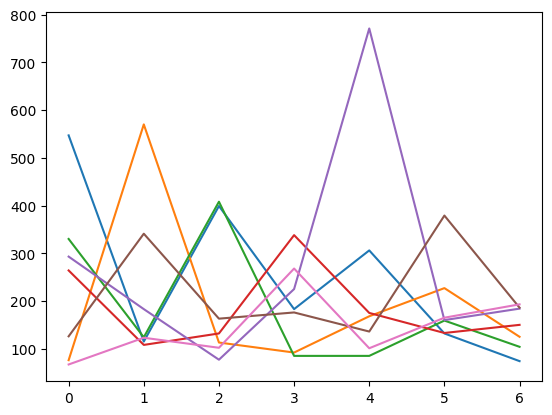

In [1015]:
ypred=dt.predict(x_test)
plt.plot(confusion_matrix(y_test, ypred))
plt.show()